In [1]:
import pandas as pd  # Used for handling data in tables
import numpy as np  # Used for numerical calculations
import torch  # PyTorch library for machine learning
from torch import nn  # Neural network modules in PyTorch
from torch.utils.data import TensorDataset, DataLoader  # Used for batching and loading data
from sklearn.metrics import mean_absolute_error, r2_score  # Evaluation metrics for model performance
from sklearn.preprocessing import StandardScaler  # Used for scaling (normalizing) data
import matplotlib.pyplot as plt  # Used for plotting graphs
from skopt import gp_minimize # Used for Bayesian Optimization

In [2]:
# Step 1: Load Data
print('Step 1: Loading Data...')
data = """material,temperature,current,voltage,energy_density,cycle_life,charge_rate,thermal_stability
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
"""


# Read the data into a pandas DataFrame (table format)
from io import StringIO
df = pd.read_csv(StringIO(data))  # Reads the CSV data into a dataframe
print("Data loaded:")
print(df.head())  # Displays the first few rows of the data

Step 1: Loading Data...
Data loaded:
   material  temperature  current  voltage  energy_density  cycle_life  \
0      0.20           25      1.5      3.7             180         500   
1      0.30           30      1.2      3.8             190         450   
2      0.25           35      1.0      3.9             200         550   
3      0.40           40      2.0      3.6             210         400   
4      0.35           45      1.8      3.7             220         420   

   charge_rate  thermal_stability  
0          1.0               0.80  
1          1.5               0.75  
2          1.2               0.90  
3          1.8               0.70  
4          1.7               0.85  


In [3]:
# Step 2: Preparing Features and Target
print('\nStep 2: Preparing Features and Target...')
X = df.drop(columns=["cycle_life"])  # Remove the 'cycle_life' column, keeping everything else as features
y = df["cycle_life"]  # 'cycle_life' is the target variable we want to predict

print("Features:")
print(X.head())  # Display the features (inputs)
print("\nTarget:")
print(y.head())  # Display the target variable (cycle life)

X = X.values  # Convert the features into a numpy array (for easier handling by PyTorch)
y = y.values  # Convert the target into a numpy array



Step 2: Preparing Features and Target...
Features:
   material  temperature  current  voltage  energy_density  charge_rate  \
0      0.20           25      1.5      3.7             180          1.0   
1      0.30           30      1.2      3.8             190          1.5   
2      0.25           35      1.0      3.9             200          1.2   
3      0.40           40      2.0      3.6             210          1.8   
4      0.35           45      1.8      3.7             220          1.7   

   thermal_stability  
0               0.80  
1               0.75  
2               0.90  
3               0.70  
4               0.85  

Target:
0    500
1    450
2    550
3    400
4    420
Name: cycle_life, dtype: int64


In [4]:
# Step 3: Data Preprocessing
print('\nStep 3: Data Preprocessing...')
scaler = StandardScaler()  # Initialize the scaler to normalize data
X_scaled = scaler.fit_transform(X)  # Normalize the feature data (to have zero mean and unit variance)
print('Data has been scaled using StandardScaler.')



Step 3: Data Preprocessing...
Data has been scaled using StandardScaler.


In [13]:
# Step 4: Define the Neural Network
print('\nStep 4: Defining the Neural Network...')
class CustomBatteryNet(nn.Module):  # Define the neural network class
    def __init__(self, input_size, hidden_layers=[16, 8], activation_function=nn.ReLU()):
        super(CustomBatteryNet, self).__init__()
        layers = []
        in_features = input_size  # Initial input size (number of features)
        for hidden_size in hidden_layers:  # Loop to create hidden layers
            layers.append(nn.Linear(in_features, hidden_size))  # Fully connected layer
            layers.append(activation_function)  # Activation function (non-linearity)
            in_features = hidden_size  # Update input size for next layer
        layers.append(nn.Linear(in_features, 1))  # Output layer (predicts one value: cycle life)
        self.network = nn.Sequential(*layers)  # Sequential model

    def forward(self, x):
        return self.network(x)  # Define forward pass (how data flows through the network)

# Initialize the model with user customization options
hidden_layers = [16, 8]  # Two hidden layers with 16 and 8 neurons
activation_function = nn.ReLU()  # ReLU activation function (you can try others like Tanh or Sigmoid)
input_size = X.shape[1]  # Number of features (input size)
model = CustomBatteryNet(input_size, hidden_layers, activation_function)
print(model)


Step 4: Defining the Neural Network...
CustomBatteryNet(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [14]:
# Step 5: Training the Neural Network
print('\nStep 5: Training the Neural Network...')
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Convert data into PyTorch tensors (needed for model)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape the target (column vector)

# Create DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)  # Package data into a dataset
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Load data in batches of 8

# Define the Loss function (how we measure error) and Optimizer (how we adjust weights)
criterion = nn.MSELoss()  # Mean Squared Error (how far off predictions are from actual values)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Adam optimizer with learning rate and weight decay

# Training Loop
num_epochs = 200  # Number of times the model will go through the entire dataset
print_every = 20  # Print progress every 20 epochs
loss_history = []  # Track the loss for plotting later

# Main training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients (important for optimization)
        outputs = model(inputs)  # Forward pass: calculate predictions
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagate error to update model weights
        optimizer.step()  # Perform one step of optimization
        epoch_loss += loss.item()  # Track the loss for the epoch
    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    loss_history.append(avg_loss)
    if (epoch+1) % print_every == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print progress


Step 5: Training the Neural Network...
Epoch [1/200], Loss: 219641.6289
Epoch [20/200], Loss: 87920.1445
Epoch [40/200], Loss: 14155.3933
Epoch [60/200], Loss: 4725.7372
Epoch [80/200], Loss: 1282.2165
Epoch [100/200], Loss: 336.0279
Epoch [120/200], Loss: 127.0405
Epoch [140/200], Loss: 46.1340
Epoch [160/200], Loss: 25.7716
Epoch [180/200], Loss: 16.8065
Epoch [200/200], Loss: 11.8596



Step 6: Evaluating the Model...
Mean Absolute Error (MAE): 2.63
R² Score: 1.00

Predictions vs True Values:
Sample 1: Predicted: 501.71, True: 500.00
Sample 2: Predicted: 448.47, True: 450.00
Sample 3: Predicted: 552.10, True: 550.00
Sample 4: Predicted: 401.32, True: 400.00
Sample 5: Predicted: 421.26, True: 420.00
Sample 6: Predicted: 596.71, True: 600.00
Sample 7: Predicted: 350.86, True: 350.00
Sample 8: Predicted: 378.92, True: 380.00
Sample 9: Predicted: 442.17, True: 450.00
Sample 10: Predicted: 505.36, True: 500.00
Sample 11: Predicted: 501.71, True: 500.00
Sample 12: Predicted: 448.47, True: 450.00
Sample 13: Predicted: 552.10, True: 550.00
Sample 14: Predicted: 401.32, True: 400.00
Sample 15: Predicted: 421.26, True: 420.00
Sample 16: Predicted: 596.71, True: 600.00
Sample 17: Predicted: 350.86, True: 350.00
Sample 18: Predicted: 378.92, True: 380.00
Sample 19: Predicted: 442.17, True: 450.00
Sample 20: Predicted: 505.36, True: 500.00
Sample 21: Predicted: 501.71, True: 500.

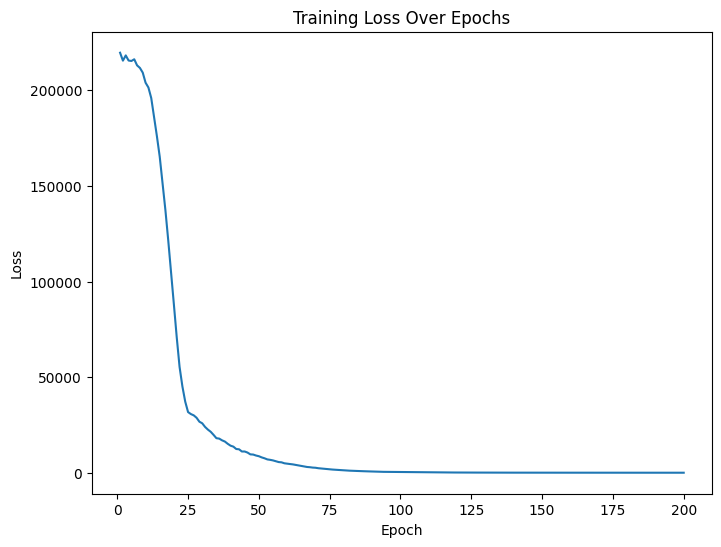

In [15]:
# Step 6: Evaluating the Model
print('\nStep 6: Evaluating the Model...')
model.eval()  # Set the model to evaluation mode (no gradients)
with torch.no_grad():  # Disable gradient calculation (faster)
    predictions = model(X_tensor).numpy().flatten()  # Get predictions
    mae = mean_absolute_error(y, predictions)  # Calculate Mean Absolute Error (MAE)
    r2 = r2_score(y, predictions)  # Calculate R-squared score (how well predictions match actual values)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    print("\nPredictions vs True Values:")
    for i, (pred, true) in enumerate(zip(predictions, y)):
        print(f"Sample {i+1}: Predicted: {pred:.2f}, True: {true:.2f}")

# Plot Loss History
plt.figure(figsize=(8,6))  # Create a plot of training loss over time
plt.plot(range(1, num_epochs+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()



Step 7: Visualizing Predictions...


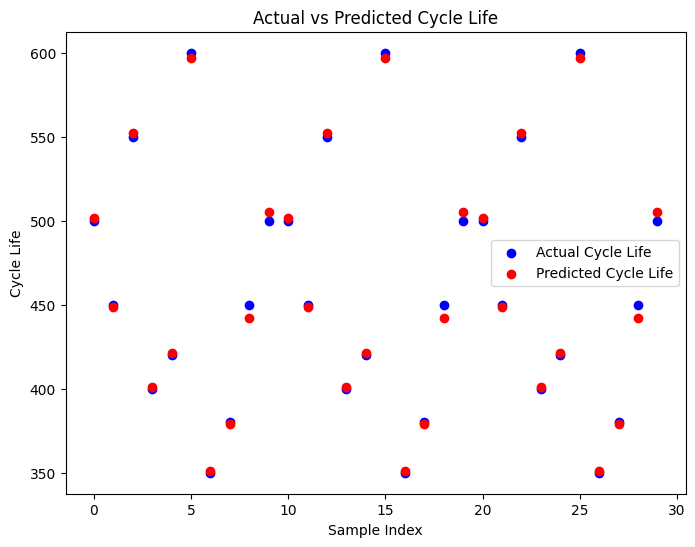

In [16]:
# Step 7: Visualizing Predictions
print('\nStep 7: Visualizing Predictions...')
plt.figure(figsize=(8,6))  # Plot actual vs predicted values
plt.scatter(range(len(y)), y, label='Actual Cycle Life', color='blue')
plt.scatter(range(len(y)), predictions, label='Predicted Cycle Life', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Cycle Life')
plt.title('Actual vs Predicted Cycle Life')
plt.legend()
plt.show()


Step 8: Creating Heatmaps and Scatter Plots...
Creating Heatmap of Predicted Cycle Life vs Material and Temperature...


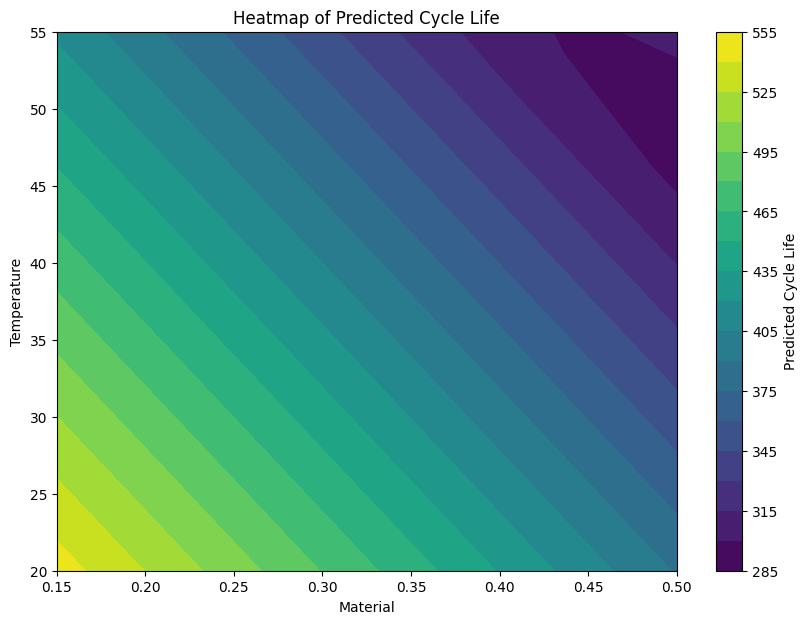

Creating Scatter Plots for each variable...


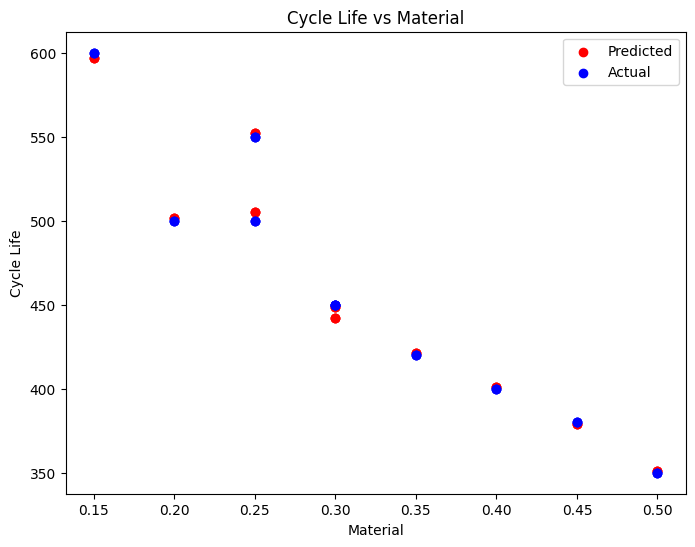

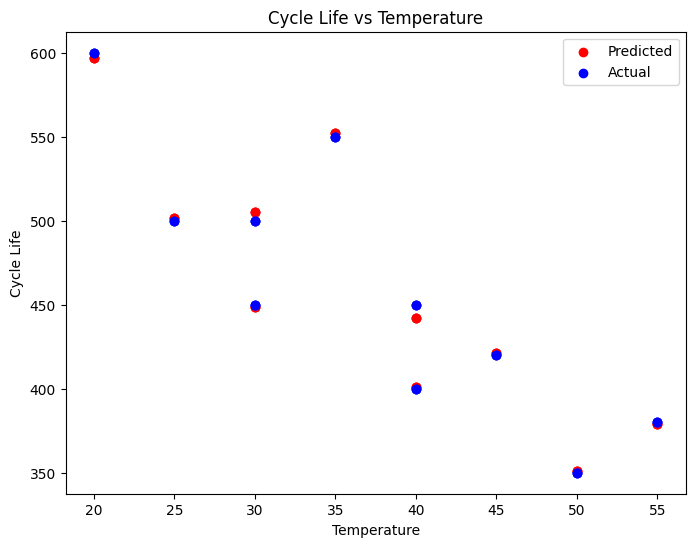

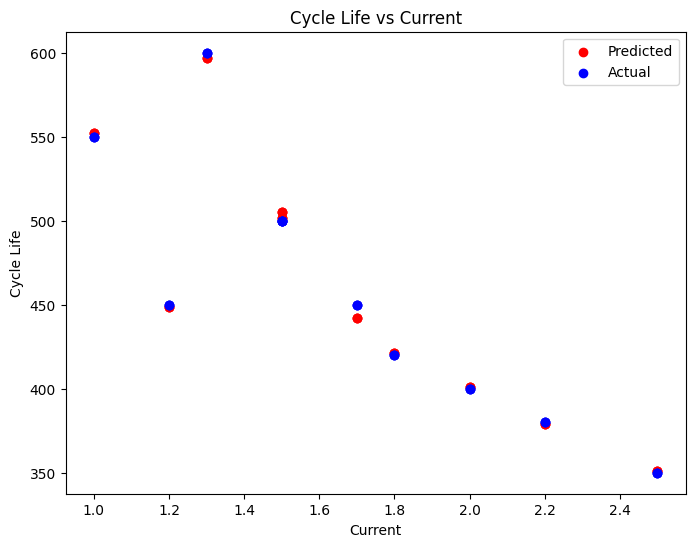

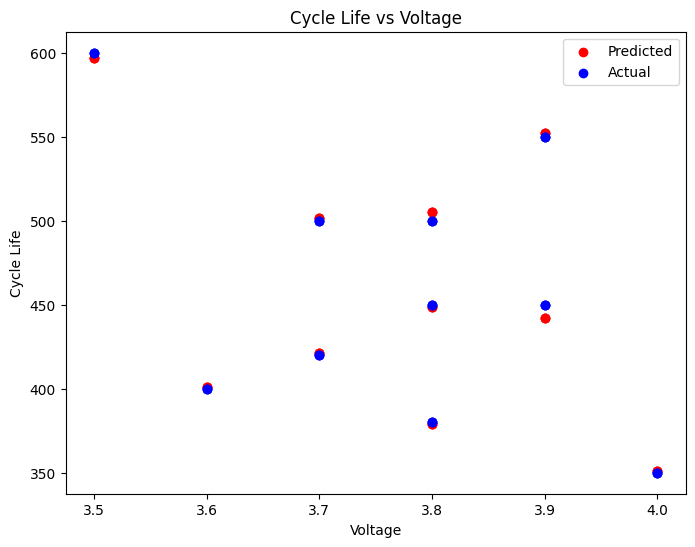

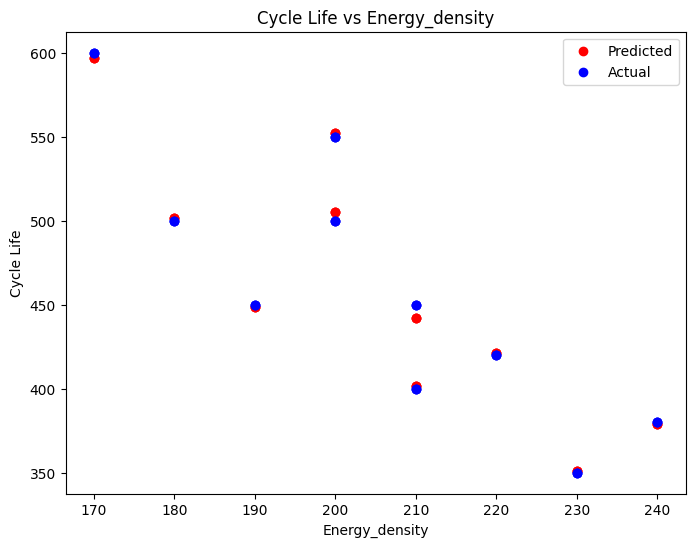

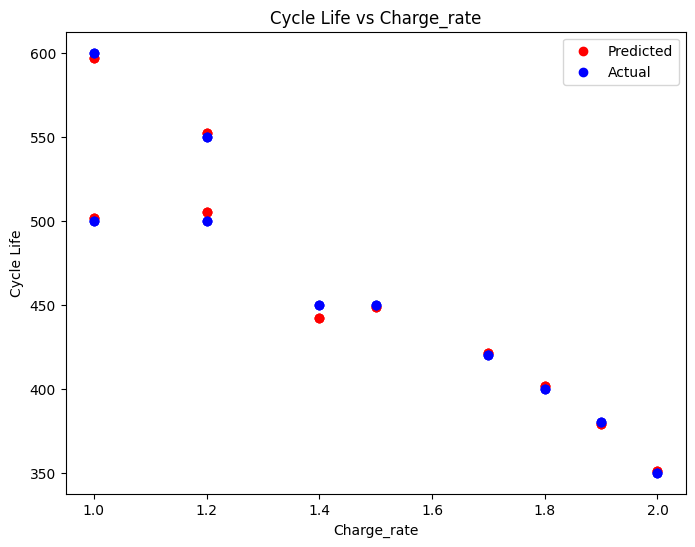

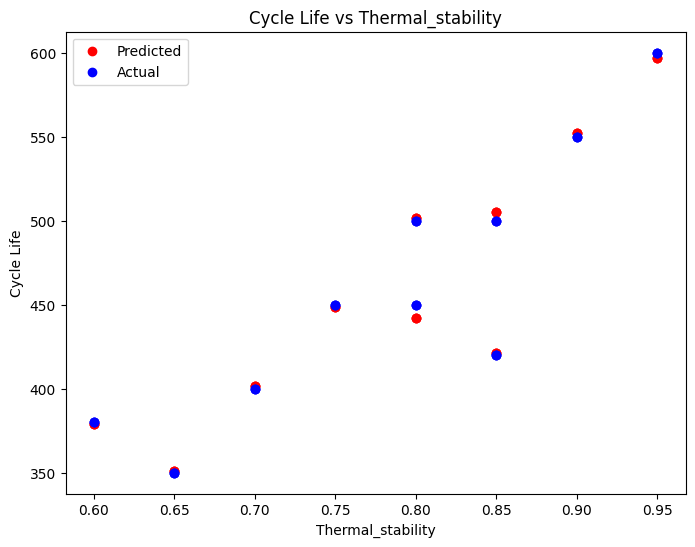

In [18]:
# Step 8: Creating Heatmaps and Scatter Plots
print('\nStep 8: Creating Heatmaps and Scatter Plots...')
variables = ['material', 'temperature', 'current', 'voltage', 'energy_density', 'charge_rate', 'thermal_stability']

# Create a DataFrame for plotting
plot_data = pd.DataFrame(X, columns=variables)
plot_data['Actual Cycle Life'] = y
plot_data['Predicted Cycle Life'] = predictions

# Heatmap of Predicted Cycle Life vs Material and Temperature
print('Creating Heatmap of Predicted Cycle Life vs Material and Temperature...')
material_range = np.linspace(X[:,0].min(), X[:,0].max(), 50)
temperature_range = np.linspace(X[:,1].min(), X[:,1].max(), 50)
material_grid, temperature_grid = np.meshgrid(material_range, temperature_range)
grid_points = np.c_[material_grid.ravel(), temperature_grid.ravel()]

# Fix other variables at their mean values
fixed_values = X.mean(axis=0)[2:]  # Exclude 'material' and 'temperature'

# Create input features for prediction
X_grid = np.hstack((
    grid_points,
    np.tile(fixed_values, (grid_points.shape[0],1))
))

# Scale the grid inputs
X_grid_scaled = scaler.transform(X_grid)
X_grid_tensor = torch.tensor(X_grid_scaled, dtype=torch.float32)

# Predict on the grid using the trained model
model.eval()
with torch.no_grad():
    grid_predictions = model(X_grid_tensor).numpy().flatten()

# Reshape results for plotting
cycle_life_grid = grid_predictions.reshape(material_grid.shape)

# Plot Heatmap
plt.figure(figsize=(10,7))
plt.contourf(material_grid, temperature_grid, cycle_life_grid, levels=20, cmap='viridis')
plt.colorbar(label='Predicted Cycle Life')
plt.xlabel('Material')
plt.ylabel('Temperature')
plt.title('Heatmap of Predicted Cycle Life')
plt.show()

# Scatter Plots for each variable
print('Creating Scatter Plots for each variable...')
for var in variables:
    plt.figure(figsize=(8,6))
    plt.scatter(plot_data[var], plot_data['Predicted Cycle Life'], label='Predicted', color='red')
    plt.scatter(plot_data[var], plot_data['Actual Cycle Life'], label='Actual', color='blue')
    plt.xlabel(var.capitalize())
    plt.ylabel('Cycle Life')
    plt.title(f'Cycle Life vs {var.capitalize()}')
    plt.legend()
    plt.show()



Step 9: Suggesting Next Experiment using Bayesian Optimization...

Suggested Next Experiment (from Bayesian Optimization):
Material: 0.15, Temperature: 20, Current: 1.0, Voltage: 4.0, Energy Density: 170, Charge Rate: 1.0, Thermal Stability: 0.95
Predicted Cycle Life: 876.1624145507812
Visualizing the suggested experiment on the heatmap...


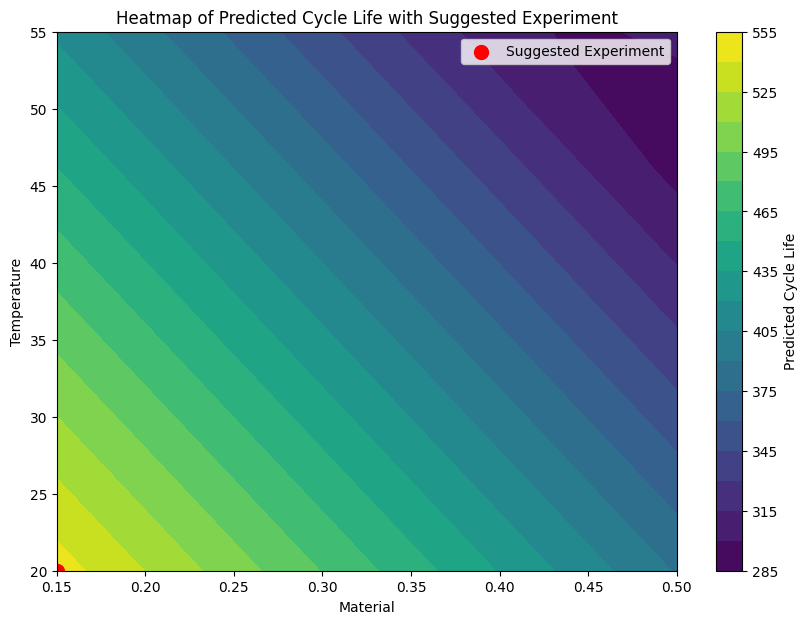

In [19]:
# Step 9: Suggesting Next Experiment using Bayesian Optimization
print('\nStep 9: Suggesting Next Experiment using Bayesian Optimization...')

# Define the objective function for Bayesian Optimization
def objective_function(params):
    material, temperature, current, voltage, energy_density, charge_rate, thermal_stability = params
    
    # Scale the input parameters
    X_input = np.array([[material, temperature, current, voltage, energy_density, charge_rate, thermal_stability]])
    X_input_scaled = scaler.transform(X_input)
    
    # Convert to tensor
    X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)
    
    # Predict the cycle life using the trained neural network
    model.eval()
    with torch.no_grad():
        predicted_cycle_life = model(X_input_tensor).numpy().flatten()[0]
    
    # We want to maximize the cycle life, so return the negative value for minimization
    return -predicted_cycle_life

# Define bounds for Bayesian Optimization
bounds = [
    (0.15, 0.5),  # material
    (20, 55),     # temperature
    (1.0, 2.5),   # current
    (3.5, 4.0),   # voltage
    (170, 240),   # energy_density
    (1.0, 2.0),   # charge_rate
    (0.6, 0.95)   # thermal_stability
]

# Run Bayesian Optimization to find the best parameters
result = gp_minimize(objective_function, dimensions=bounds, n_calls=50, random_state=42)

# Get the best parameters and predicted cycle life
best_params = result.x
best_predicted_cycle_life = -result.fun

print('\nSuggested Next Experiment (from Bayesian Optimization):')
print(f"Material: {best_params[0]}, Temperature: {best_params[1]}, Current: {best_params[2]}, "
      f"Voltage: {best_params[3]}, Energy Density: {best_params[4]}, Charge Rate: {best_params[5]}, "
      f"Thermal Stability: {best_params[6]}")
print(f"Predicted Cycle Life: {best_predicted_cycle_life}")

# Visualizing the suggested experiment on the heatmap
print('Visualizing the suggested experiment on the heatmap...')
plt.figure(figsize=(10,7))
plt.contourf(material_grid, temperature_grid, cycle_life_grid, levels=20, cmap='viridis')
plt.colorbar(label='Predicted Cycle Life')
plt.scatter(best_params[0], best_params[1], color='red', label='Suggested Experiment', s=100)
plt.xlabel('Material')
plt.ylabel('Temperature')
plt.title('Heatmap of Predicted Cycle Life with Suggested Experiment')
plt.legend()
plt.show()
